In [ ]:
## Imports
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle, Polygon, FancyArrowPatch
import matplot2tikz

In [33]:
## Pay-to-exit research questions
## RQ1 For an adversary with \alpha stake, how much does it need to pay to
## exiting validators to achieve \alpha'\leq0.33 stake in the system? In this scenario the adversary would
## reimburse all expected rewards to the validator for the next 1-2-3 (TBD) years (discounted at present value).
## RQ2 The same as in RQ1 but the adversary only reimburses the opportunity cost, i.e.,
## say the difference between validator rewards - Uniswap LP rewards (assuming Uniswap LP is the 2nd best option for validators).

## Pay-to-fork research questions
## RQ1 how much the adversary needs to pay for buying X attestations?
## RQ2 Same as RQ1 but the adversary also needs to cover attestation equivocation penalties for these X bought attestations.

## Relevant Pectra-EIPs for this work
## EIP-7002
## EIP-7549 Move the committee index out of the signature: more efficient attestation/signature aggregation

In [34]:
## Best resource on the protocol: https://eth2book.info/latest/book.pdf

In [ ]:
stakedETHamount = (
    34385053  # (2025.04.01) taken from here https://dune.com/hildobby/eth2-staking
)

# noOfValidators = (1074533)     # (2025.04.01) taken from here https://dune.com/hildobby/eth2-staking
noOfValidators = 1127967

noEpochsPerYear = 82181.25
maxIssuancePerYear = 940.8659 * math.sqrt(
    noOfValidators
)  ## the constant is coming from epochs per year (roughly)
APR = 2940.21 / math.sqrt(noOfValidators)
proposerReward = 0
attestationReward = 0
W_s = 14  # weights page 100
W_t = 26
W_h = 14
W_y = 2  # sync reward weight
W_p = 12.5  # proposer weight
W_Sigma = 64  # defined at page 109
T = stakedETHamount  # defined at page 102
n = 32  # number of increments (the validator's balance is assumed to be 32 ETH uniformly (for the sake of simplicity))
base_reward_factor = 64  # https://ethereum.stackexchange.com/questions/153722/base-reward-formula-enquiry
b = (1000000000 * base_reward_factor) / math.sqrt(
    32000000000 * noOfValidators
)  # base reward per increment

# Attestation penalties page 109 in eth2book
attestation_missing_penalty = 0.625 * T * b  # page 107
wrong_source_attestation = (-W_s - W_t) / W_Sigma
MIN_SLASHING_PENALTY_QUOTIENT_BELLATRIX = 1 / 32  # defined at page 116
# correlation penalty page 117
# other penalties

attestation_reward_per_validator = (b / 64) * 57 / 1e9  # in ETH

# Pay To attest


In [ ]:
alpha_vals = np.linspace(0.01, 0.5, 100)
beta_vals = np.linspace(0, 1, 100)

# L = 2 # fork_lengths
# F0 = 2
# k = 0.1
# canonical_length = 2
# F = F0 * np.exp(-k * L)

bribe = np.full((len(beta_vals), len(alpha_vals)), np.nan)

for i, beta in enumerate(beta_vals):
    for j, alpha in enumerate(alpha_vals):

        lhs = 2 * (1 - alpha) * (1 - beta)
        # lhs = F * (1 - beta) * (1 - alpha) * L + (1 - alpha) * canonical_length

        rhs = 0.4 + alpha + (1 - alpha) * beta
        # rhs = alpha * canonical_length + F * alpha * L + F * beta * (1 - alpha) * L

        if lhs < rhs:

            bribe[i, j] = (
                beta
                * (1 - alpha)
                * noOfValidators
                * attestation_reward_per_validator
                / 32
            )
            # bribe[i, j] = L * beta * (1 - alpha) * noOfValidators * attestation_reward_per_validator / 32


vmin_bribe = np.nanmin(bribe)
vmax_bribe = np.nanmax(bribe)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals) - 1, 11, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

## Only headvotes


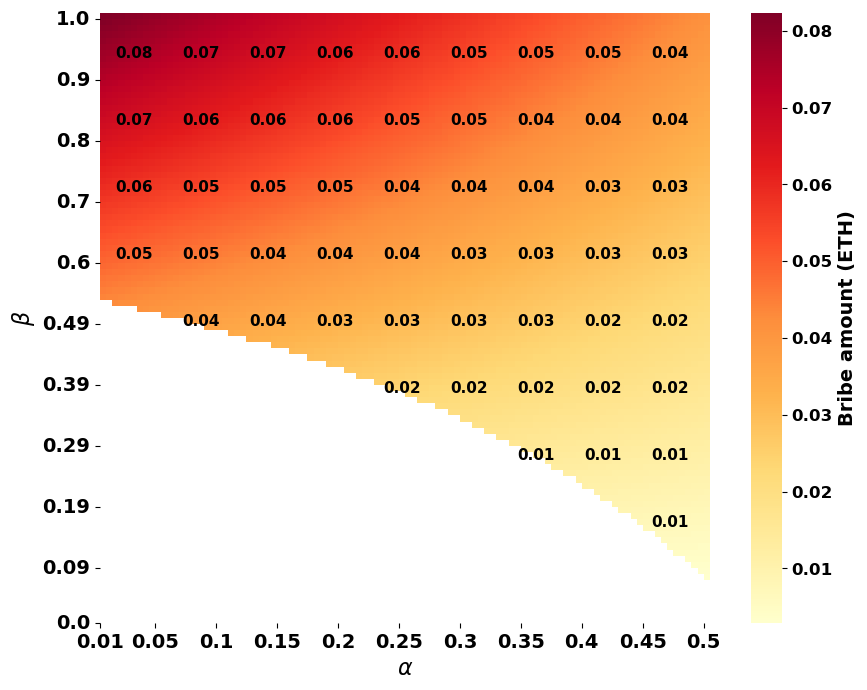

In [ ]:
alpha_vals = np.linspace(0.01, 0.5, 100)
beta_vals = np.linspace(0, 1, 100)

head_vote_reward_per_validator = (W_h / 64) * 32 * b / 1e9  # 7*b/1e9 in mETH


bribe = np.full((len(beta_vals), len(alpha_vals)), np.nan)

for i, beta in enumerate(beta_vals):
    for j, alpha in enumerate(alpha_vals):

        lhs = 2 * (1 - alpha) * (1 - beta)
        rhs = 0.4 + alpha + (1 - alpha) * beta

        if lhs < rhs:

            bribe[i, j] = (
                beta
                * (1 - alpha)
                * noOfValidators
                * head_vote_reward_per_validator
                / 32
            )


vmin_bribe = np.nanmin(bribe)
vmax_bribe = np.nanmax(bribe)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals) - 1, 11, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

plt.figure(figsize=(9, 7))
ax = sns.heatmap(
    bribe,
    cmap="YlOrRd",
    mask=np.isnan(bribe),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks[::-1],
    cbar_kws={"label": "Bribe amount (ETH)"},
    vmin=vmin_bribe,
    vmax=vmax_bribe,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight="bold")
ax.set_ylabel(r"$\beta$", fontsize=16, fontweight="bold")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight="bold")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight="bold")

ax.invert_yaxis()

for i in range(5, len(beta_vals), 11):
    for j in range(5, len(alpha_vals), 11):
        value = bribe[i, j]
        if not np.isnan(value):
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{value:.2f}",
                ha="center",
                va="center",
                fontsize=11,
                fontweight="bold",
                color="black",
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
for lbl in cbar.ax.get_yticklabels():
    lbl.set_fontweight("bold")
cbar.set_label("Bribe amount (ETH)", fontsize=14, fontweight="bold")
plt.setp(cbar.ax.get_yticklabels(), fontweight="bold")

plt.tight_layout()
# plt.savefig("PayToAttest_BribeAmount_expost.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### MEV line


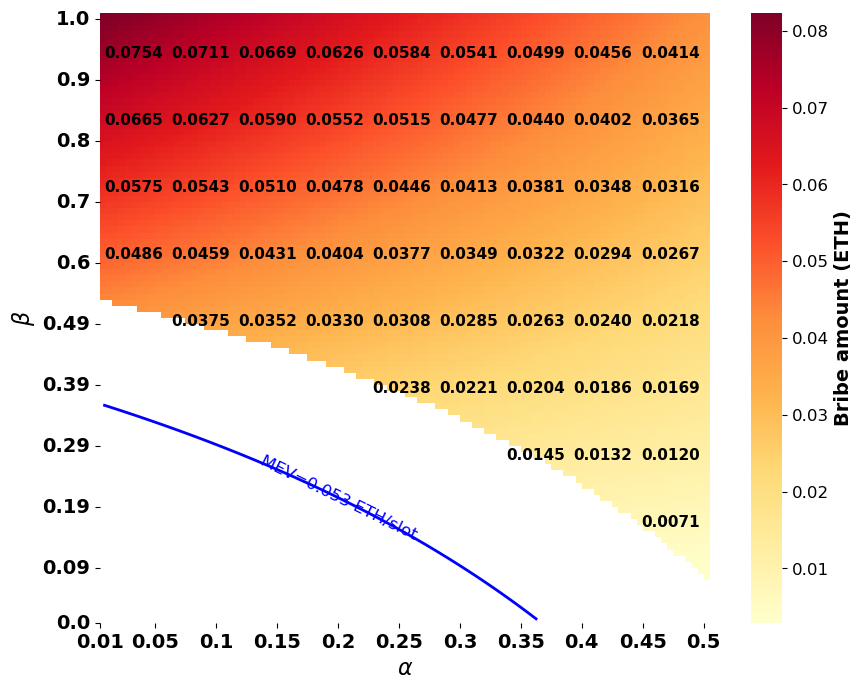

In [ ]:
plt.figure(figsize=(9, 7))
ax = sns.heatmap(
    bribe,
    cmap="YlOrRd",
    mask=np.isnan(bribe),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks[::-1],
    cbar_kws={"label": "Bribe amount (ETH)"},
    vmin=vmin_bribe,
    vmax=vmax_bribe,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight="bold")
ax.set_ylabel(r"$\beta$", fontsize=16, fontweight="bold")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight="bold")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight="bold")

ax.invert_yaxis()

for i in range(5, len(beta_vals), 11):
    for j in range(5, len(alpha_vals), 11):
        value = bribe[i, j]
        if not np.isnan(value):
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{value:.4f}",
                ha="center",
                va="center",
                fontsize=11,
                fontweight="bold",
                color="black",
            )

mev_per_slot_eth = 0.053
CS = ax.contour(
    bribe,
    levels=[mev_per_slot_eth],
    colors="blue",
    linewidths=2,
    linestyles="solid",
    origin="upper",
)
ax.clabel(
    CS,
    fmt={mev_per_slot_eth: f"MEV={mev_per_slot_eth:.3f} ETH/slot"},
    inline=False,
    fontsize=12,
)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Bribe amount (ETH)", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

### Ex-ante bribe amount heatmap


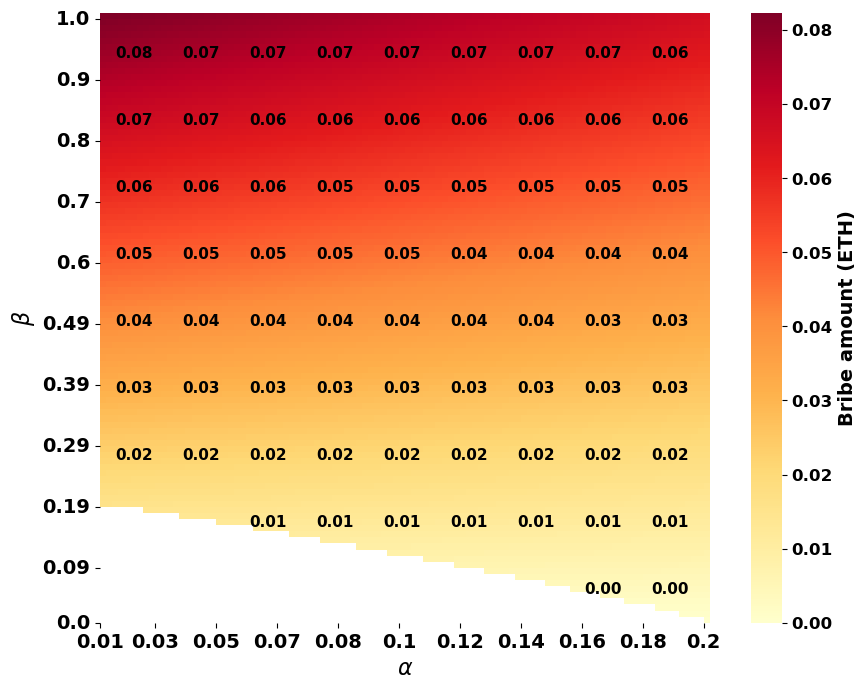

In [ ]:
pboost = 0.4
a = 1.0
h = 1.0

alpha_vals = np.linspace(0.01, 0.2, 100)
beta_vals = np.linspace(0.00, 1.00, 100)

head_vote_reward_per_validator = (W_h / 64) * 32 * b / 1e9  # ETH

y_thr = (h - pboost) / (a + 2.0 * h)

bribe = np.full((len(beta_vals), len(alpha_vals)), np.nan)

for i, beta in enumerate(beta_vals):
    for j, alpha in enumerate(alpha_vals):
        y = alpha + (1.0 - alpha) * beta
        success = (y > y_thr) and (0.0 <= beta <= 1.0)
        if success:
            bribe[i, j] = (
                beta
                * (1 - alpha)
                * (noOfValidators / 32.0)
                * head_vote_reward_per_validator
            )

vmin_bribe = np.nanmin(bribe)
vmax_bribe = np.nanmax(bribe)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals) - 1, 11, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

plt.figure(figsize=(9, 7))
ax = sns.heatmap(
    bribe,
    cmap="YlOrRd",
    mask=np.isnan(bribe),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks[::-1],
    cbar_kws={"label": "Bribe amount (mETH) — ex-ante, head-only"},
    vmin=vmin_bribe,
    vmax=vmax_bribe,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight="bold")
ax.set_ylabel(r"$\beta$", fontsize=16, fontweight="bold")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight="bold")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight="bold")
ax.invert_yaxis()

for i in range(5, len(beta_vals), 11):
    for j in range(5, len(alpha_vals), 11):
        value = bribe[i, j]
        if not np.isnan(value):
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{value:.2f}",
                ha="center",
                va="center",
                fontsize=11,
                fontweight="bold",
                color="black",
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
for lbl in cbar.ax.get_yticklabels():
    lbl.set_fontweight("bold")
cbar.set_label("Bribe amount (ETH)", fontsize=14, fontweight="bold")
plt.setp(cbar.ax.get_yticklabels(), fontweight="bold")
plt.tight_layout()
plt.savefig("PayToAttest_BribeAmount_exante.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### PayToAttest — min bribery requiremen


where β* is a threshold value (the minimum β required for success)


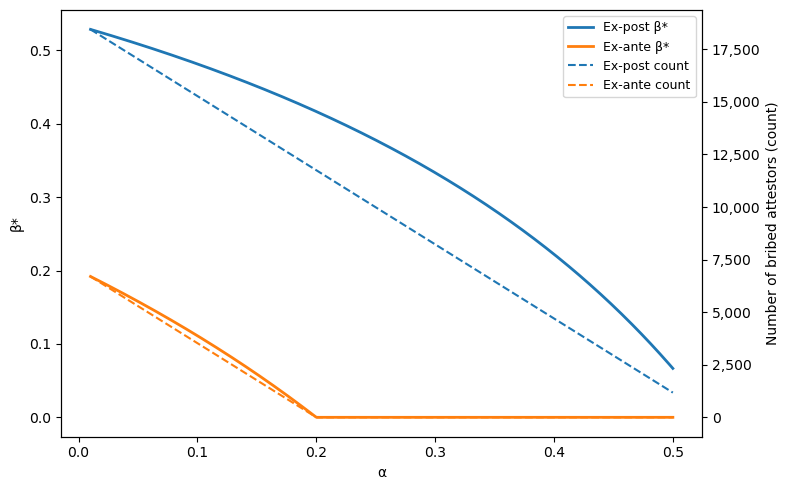

In [ ]:
pboost = 0.4
attestors_per_slot = noOfValidators / 32.0
a, h = 1, 1  # ex-ante chain parameter

alpha = np.linspace(0.01, 0.5, 500)


def beta_min_expost(alpha, pboost=0.4):
    # Eq3: 2(1-alpha)(1-beta) <= pboost + alpha + (1 - alpha)beta  ==>  beta* = (2 - 3alpha - pboost) / (3(1 - alpha))
    num = 2.0 - 3.0 * alpha - pboost
    den = 3.0 * (1.0 - alpha)
    beta_star = num / den
    beta_star = np.where(beta_star <= 0, 0.0, beta_star)
    beta_star = np.where(beta_star > 1.0, np.nan, beta_star)
    return beta_star


def beta_min_exante(alpha, a=1, h=1, pboost=0.4):
    # Eq5: (a + h) * (alpha + (1 - alpha)beta) + pboost > h * (1 - (alpha + (1 - alpha)beta))
    # y = alpha + (1 - alpha)beta ==> (a + 2h) * y > h - pboost ==> y_thr = (h - pboost) / (a + 2h)
    y_thr = (h - pboost) / (a + 2.0 * h)
    if y_thr <= 0:
        return np.zeros_like(alpha)
    if y_thr >= 1.0:
        return np.full_like(alpha, np.nan)
    den = 1.0 - alpha
    beta_star = (y_thr - alpha) / den
    beta_star = np.where(beta_star <= 0, 0.0, beta_star)
    beta_star = np.where(beta_star > 1.0, np.nan, beta_star)
    return beta_star


beta_expost = beta_min_expost(alpha, pboost=pboost)
beta_exante = beta_min_exante(alpha, a=a, h=h, pboost=pboost)

count_expost = (1.0 - alpha) * beta_expost * attestors_per_slot
count_exante = (1.0 - alpha) * beta_exante * attestors_per_slot

print("where β* is a threshold value (the minimum β required for success)")

fig, ax1 = plt.subplots(figsize=(8, 5))

(l1,) = ax1.plot(alpha, beta_expost, label="Ex-post β*", linewidth=2)
(l2,) = ax1.plot(alpha, beta_exante, label="Ex-ante β*", linewidth=2)
ax1.set_xlabel("α")
ax1.set_ylabel("β*")

ax2 = ax1.twinx()
(l3,) = ax2.plot(
    alpha, count_expost, linestyle="--", color=l1.get_color(), label="Ex-post count"
)
(l4,) = ax2.plot(
    alpha, count_exante, linestyle="--", color=l2.get_color(), label="Ex-ante count"
)
ax2.set_ylabel("Number of bribed attestors (count)")
ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

lines = [l1, l2, l3, l4]
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc="upper right", fontsize=9)

plt.tight_layout()
plt.show()

### PayToAttest cost vs time


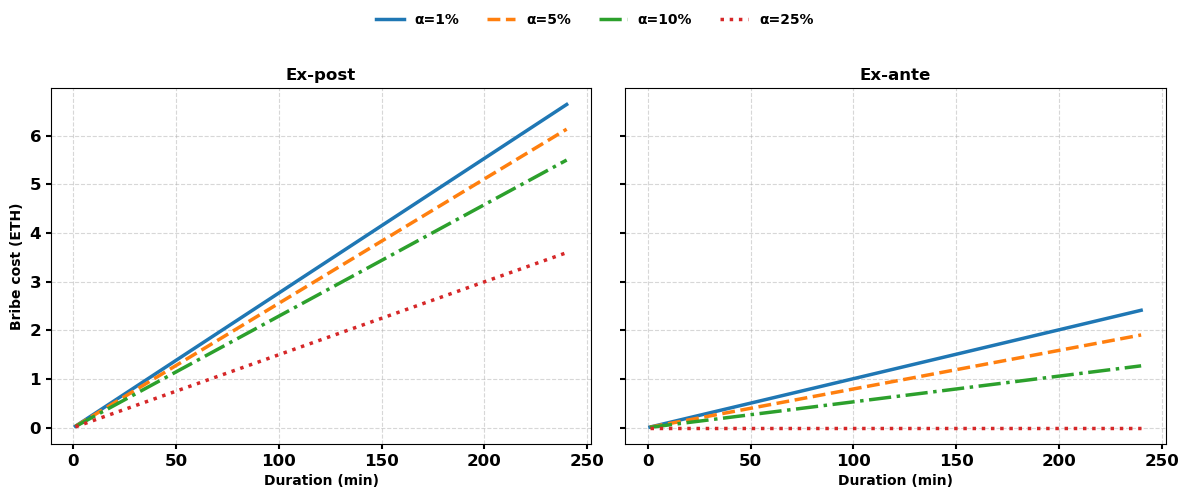

In [ ]:
attestors_per_slot = noOfValidators / 32
pboost = 0.4
slot_seconds = 12
a, h = 1, 1
att_reward_eth = (b / 64.0) * 57.0 / 1e9


def beta_min_expost(alpha, pboost=0.4):
    # Eq3: beta* = (2 - 3alpha - pboost) / (3(1 - alpha))
    num = 2.0 - 3.0 * alpha - pboost
    den = 3.0 * (1.0 - alpha)
    if den <= 0:
        return np.nan
    beta_star = num / den
    if beta_star <= 0:
        return 0.0
    if beta_star > 1.0:
        return np.nan
    return beta_star


def beta_min_exante(alpha, a=1, h=1, pboost=0.4):
    # Eq5: y > (h - pboost)/(a + 2h), y = alpha + (1 - alpha)beta  ->  beta* = (y_thr - alpha)/(1 - alpha)
    y_thr = (h - pboost) / (a + 2.0 * h)
    if y_thr <= 0:
        return 0.0
    if y_thr >= 1:
        return np.nan
    den = 1.0 - alpha
    if den <= 0:
        return np.nan
    beta_star = (y_thr - alpha) / den
    if beta_star <= 0:
        return 0.0
    if beta_star > 1.0:
        return np.nan
    return beta_star


def per_slot_cost(alpha, mode="expost"):
    beta_star = (
        beta_min_expost(alpha, pboost)
        if mode == "expost"
        else beta_min_exante(alpha, a, h, pboost)
    )
    if not np.isfinite(beta_star):
        return np.nan
    return (1.0 - alpha) * beta_star * attestors_per_slot * att_reward_eth


minutes = np.arange(1, 241)
slots_for = np.ceil((minutes * 60) / slot_seconds)

alphas = [0.01, 0.05, 0.10, 0.25]

linestyles = ["-", "--", "-.", ":"]
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
style_map = {
    a: {"ls": linestyles[i % len(linestyles)], "color": colors[i % len(colors)]}
    for i, a in enumerate(alphas)
}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for a_i in alphas:
    c_expost = per_slot_cost(a_i, "expost")
    cost_expost = slots_for * c_expost
    axes[0].plot(
        minutes,
        cost_expost,
        label=f"α={a_i:.0%}",
        linestyle=style_map[a_i]["ls"],
        color=style_map[a_i]["color"],
        linewidth=2.5,
    )
axes[0].set_title("Ex-post", fontweight="bold")
axes[0].set_xlabel("Duration (min)", fontweight="bold")
axes[0].set_ylabel("Bribe cost (ETH)", fontweight="bold")
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

for a_i in alphas:
    c_exante = per_slot_cost(a_i, "exante")
    cost_exante = slots_for * c_exante
    axes[1].plot(
        minutes,
        cost_exante,
        label=f"α={a_i:.0%}",
        linestyle=style_map[a_i]["ls"],
        color=style_map[a_i]["color"],
        linewidth=2.5,
    )
axes[1].set_title("Ex-ante", fontweight="bold")
axes[1].set_xlabel("Duration (min)", fontweight="bold")
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

for ax in axes:
    ax.tick_params(axis="both", labelsize=12, width=1.5)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight("bold")

legend_lines = [
    Line2D(
        [0],
        [0],
        linestyle=style_map[a]["ls"],
        color=style_map[a]["color"],
        linewidth=2.5,
    )
    for a in alphas
]
leg = fig.legend(
    legend_lines,
    [f"α={a:.0%}" for a in alphas],
    loc="upper center",
    ncol=len(alphas),
    frameon=False,
)
for txt in leg.get_texts():
    txt.set_fontweight("bold")

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.savefig("PayToAttest_costVStime.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Pay To Exit


In [ ]:
def getMaxIssuancePerYear(noOfValidators):
    return 940.8659 * math.sqrt(noOfValidators)


def getAPR(noOfValidators):
    return 2940.21 / math.sqrt(noOfValidators)

In [ ]:
# constants
eth_usd_rate = 3668.77
r = 0.08
Y = 9

# functions


def g(N, k, y=Y, r=r):
    return (
        (32 / 100)
        * ((2940.21 / math.sqrt(N - k)) + (267161.5 / (N - k)))
        * ((1 - (1 + r) ** (-y)) / r)
    )

<>:36: SyntaxWarning: invalid escape sequence '\&'
<>:43: SyntaxWarning: invalid escape sequence '\&'
<>:50: SyntaxWarning: invalid escape sequence '\&'
<>:36: SyntaxWarning: invalid escape sequence '\&'
<>:43: SyntaxWarning: invalid escape sequence '\&'
<>:50: SyntaxWarning: invalid escape sequence '\&'
/var/folders/bs/mcr4twx959ndzlf0j55vycz00000gn/T/ipykernel_14583/1560048601.py:36: SyntaxWarning: invalid escape sequence '\&'
  label="y=20 \& r=0.12",
/var/folders/bs/mcr4twx959ndzlf0j55vycz00000gn/T/ipykernel_14583/1560048601.py:43: SyntaxWarning: invalid escape sequence '\&'
  label="y=5 \& r=0.05",
/var/folders/bs/mcr4twx959ndzlf0j55vycz00000gn/T/ipykernel_14583/1560048601.py:50: SyntaxWarning: invalid escape sequence '\&'
  label="y=15 \& r=0.1",


<Figure size 640x480 with 0 Axes>

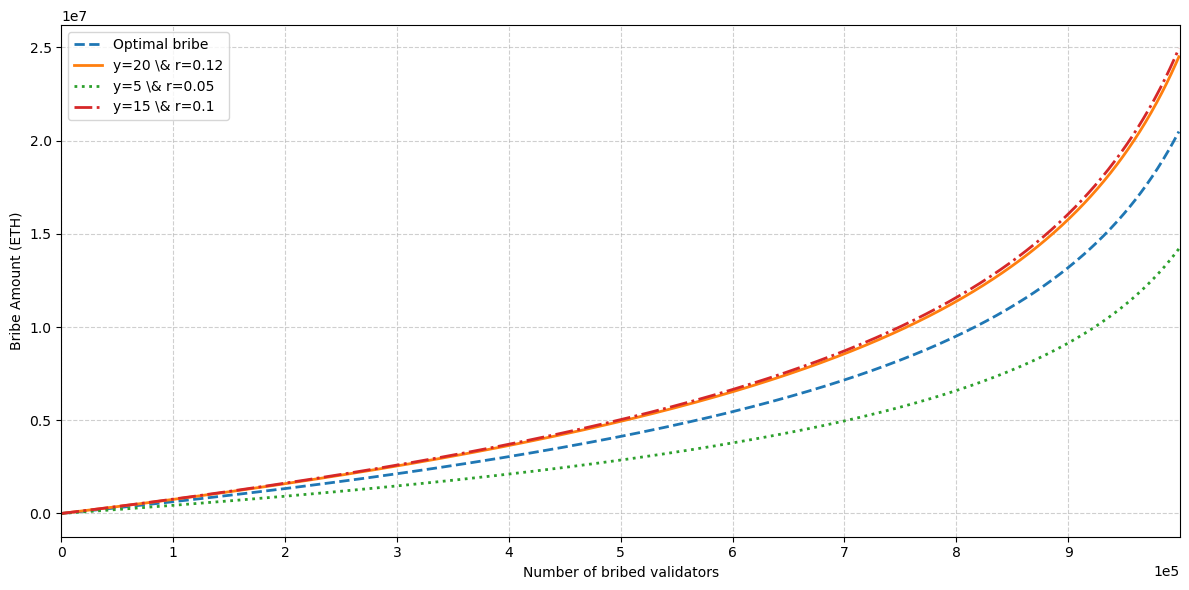

In [44]:
max_bribed_validators = 1_000_000

y = np.empty(max_bribed_validators, dtype=np.float64)
for i in range(max_bribed_validators):
    y[i] = g(noOfValidators, i, 9, 0.08) * i

y2 = np.empty(max_bribed_validators, dtype=np.float64)
for i in range(max_bribed_validators):
    y2[i] = g(noOfValidators, i, 20, 0.12) * i

y3 = np.empty(max_bribed_validators, dtype=np.float64)
for i in range(max_bribed_validators):
    y3[i] = g(noOfValidators, i, 5, 0.05) * i

y4 = np.empty(max_bribed_validators, dtype=np.float64)
for i in range(max_bribed_validators):
    y4[i] = g(noOfValidators, i, 15, 0.1) * i

x = np.arange(1, max_bribed_validators + 1)

matplot2tikz.clean_figure()

plt.figure(figsize=(12, 6))
skip = 1000

plt.plot(
    x[::skip],
    y[::skip],
    label="Optimal bribe",
    linestyle="--",
    linewidth=2.0,
)
plt.plot(
    x[::skip],
    y2[::skip],
    label="y=20 \& r=0.12",
    linestyle="-",
    linewidth=2.0,
)
plt.plot(
    x[::skip],
    y3[::skip],
    label="y=5 \& r=0.05",
    linestyle=":",
    linewidth=2.0,
)
plt.plot(
    x[::skip],
    y4[::skip],
    label="y=15 \& r=0.1",
    linestyle="-.",
    linewidth=2.0,
)

# plt.plot(
#     x[::skip],
#     cum_pv_churn[::skip],
#     label=f"Present value of {years} year bribe stream with r={discount_rate:.0}\% (ETH) — churn-limited exit queue",
#     linestyle="-.",
#     linewidth=2.0,
# )

plt.xlabel("Number of bribed validators")
plt.ylabel("Bribe Amount (ETH)")
plt.ticklabel_format(style="plain", axis="y")
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().xaxis.get_major_formatter().set_powerlimits((1, 2))
plt.xlim(1, max_bribed_validators)
step = max(1, max_bribed_validators // 10)
plt.xticks(np.arange(1, max_bribed_validators + 1, step))

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
matplot2tikz.save("payToExitBribeAmounts.tex")
plt.show()

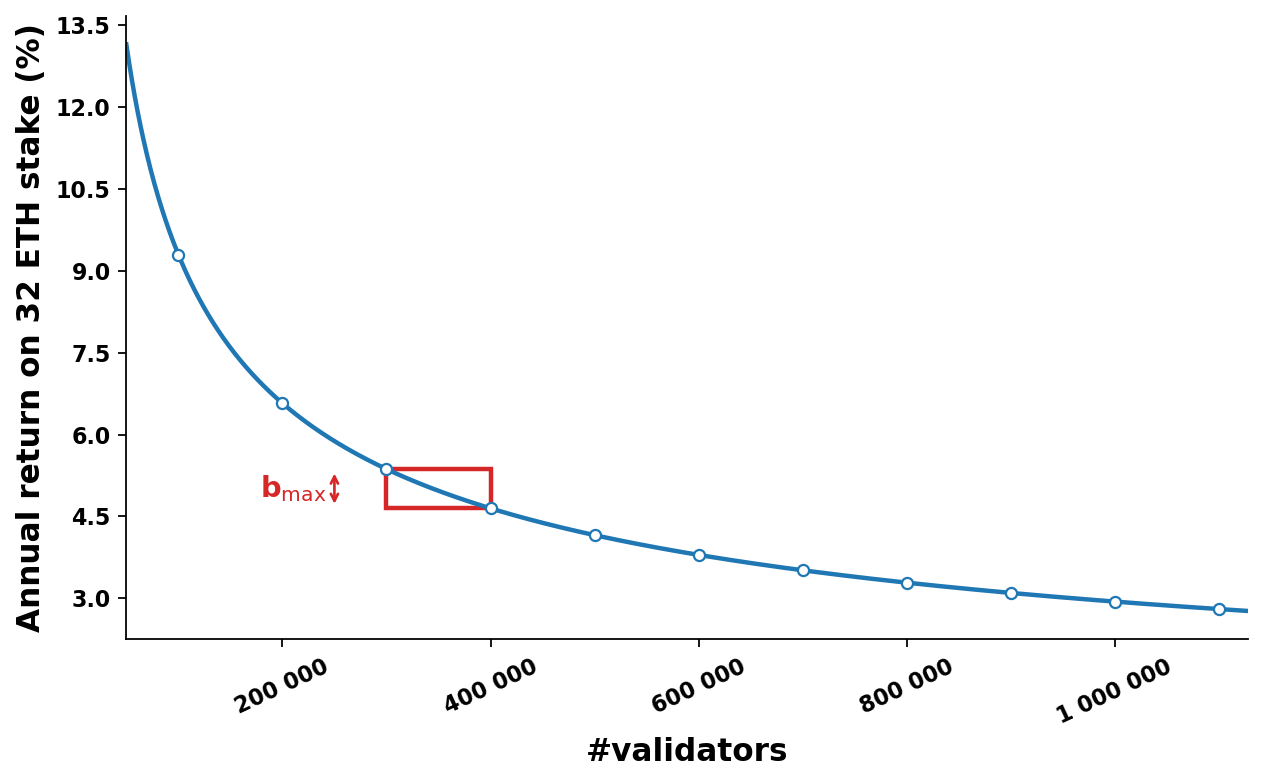

In [ ]:
apr_vec = np.vectorize(getAPR, otypes=[float])

N = np.linspace(50_000, noOfValidators, 1200)
y = apr_vec(N)

fig, ax = plt.subplots(figsize=(8, 5), dpi=160)

curve_color = "tab:blue"
rect_color = "tab:red"
hatch_color = "tab:purple"

ax.plot(N, y, color=curve_color, linewidth=2)
N_marks = np.arange(100_000, noOfValidators + 1, 100_000)
ax.plot(
    N_marks,
    apr_vec(N_marks),
    "o",
    markersize=5,
    markerfacecolor="white",
    markeredgecolor=curve_color,
    linewidth=0,
)

ax.set_xlabel("#validators", fontsize=14, fontweight="bold")
ax.set_ylabel("Annual return on 32 ETH stake (%)", fontsize=14, fontweight="bold")

ax.set_xlim(50_000, noOfValidators)
ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda v, pos: f"{int(v):,}".replace(",", " "))
)
ax.grid(False)
for s in ("top", "right"):
    ax.spines[s].set_visible(False)

x1, x2 = 300_000, 400_000
y1 = getAPR(x1)
y2 = getAPR(x2)

rect = Rectangle(
    (x1, y2), (x2 - x1), (y1 - y2), fill=False, linewidth=2, edgecolor=rect_color
)
ax.add_patch(rect)

arrow = FancyArrowPatch(
    (x1 - 50_000, y2),
    (x1 - 50_000, y1),
    arrowstyle="<->",
    mutation_scale=8,
    linewidth=1.2,
    color=rect_color,
)
ax.add_patch(arrow)
ax.text(
    x1 - 90_000,
    (y1 + y2) / 2,
    r"$\mathbf{b_{\max}}$",
    ha="center",
    va="center",
    fontsize=13,
    color=rect_color,
)

mask = (N >= x1) & (N <= x2)
x_clip = N[mask]
y_clip = y[mask]
area = ax.fill_between(
    x_clip, y2, y_clip, where=(y_clip > y2), facecolor="white", alpha=0.0
)
area.set_hatch("///")
area.set_edgecolor(hatch_color)

ax.tick_params(axis="x", labelrotation=25)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontweight("bold")

matplot2tikz.save("payToExit_APR.tex")
plt.tight_layout()
plt.show()

In [ ]:
N = noOfValidators
k = 340000

b_star = (g(N, k, Y, r) + g(N, k + 1, Y, r)) / 2

print(f"b* = {b_star:.6f} ETH")

b* = 7.298988 ETH


<Figure size 640x480 with 0 Axes>

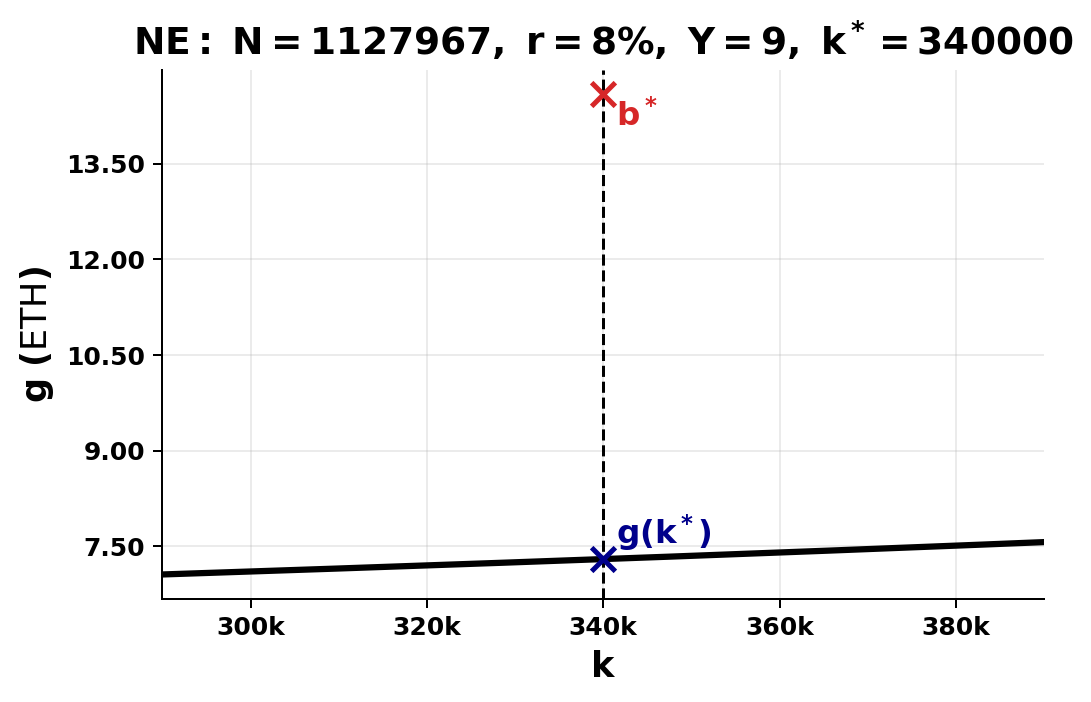

In [ ]:
b_star = g(N, k, Y, r) + g(N, k - 1, Y, r)

left = max(0, k - 50_000)
right = min(N - 1, k + 50_000)
ks = np.unique(np.linspace(left, right, 200, dtype=int))
g_vals = np.array([g(N, kk, Y, r) for kk in ks])

matplot2tikz.clean_figure()

fig, ax = plt.subplots(figsize=(6, 4), dpi=180)
ax.plot(ks, g_vals, linewidth=2.5, color="black")
ax.axvline(k, linestyle="--", linewidth=1.2, color="black")

ax.scatter([k], [b_star], s=90, marker="x", color="tab:red", linewidths=2, zorder=4)

g_k = g(N, k, Y, r)
ax.scatter([k], [g_k], s=90, marker="x", color="darkblue", linewidths=2, zorder=4)

ax.annotate(
    r"$\mathbf{b^*}$",
    xy=(k, b_star),
    xytext=(5, -2),
    textcoords="offset points",
    ha="left",
    va="top",
    fontsize=13,
    color="tab:red",
    zorder=6,
)
ax.annotate(
    r"$\mathbf{g(k^*)}$",
    xy=(k, g_k),
    xytext=(5, 2),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=13,
    color="darkblue",
    zorder=6,
)

ax.set_xlim(left, right)
ax.set_xlabel(r"$\mathbf{k}$", fontsize=14)
ax.set_ylabel(r"$\mathbf{g\ (\text{ETH})}$", fontsize=14)
ax.set_title(
    rf"$\mathbf{{NE:\ N={N},\ r={int(r*100)}\%,\ Y={Y},\ k^*={k}}}$", fontsize=15
)

ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{int(v/1000)}k"))

ax.grid(True, which="major", alpha=0.25)
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontweight("bold")

plt.tight_layout()
matplot2tikz.save("Numerical_example_5.2.tex")

plt.show()

### Bribe amount heatmap


<Figure size 640x480 with 0 Axes>

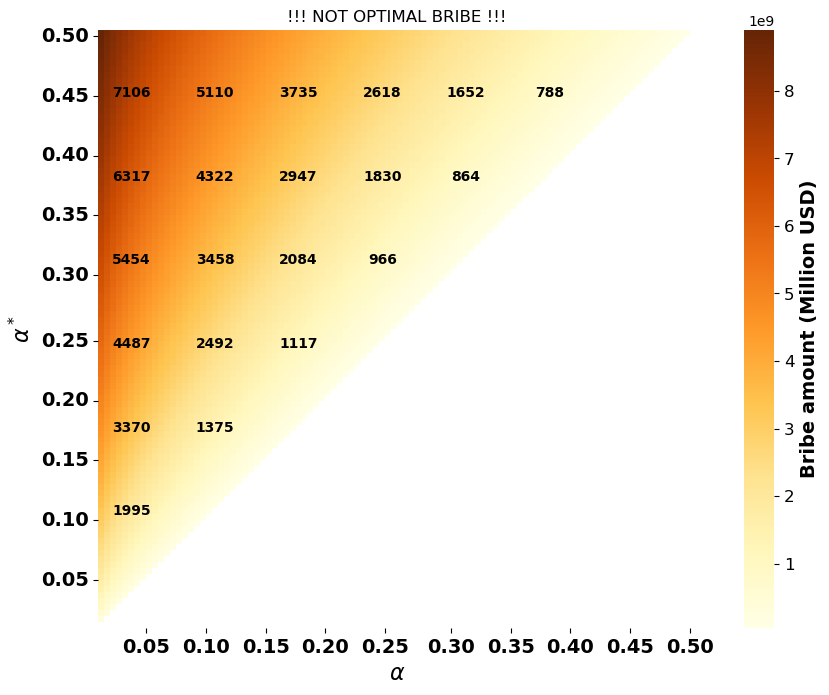

In [ ]:
def compute_bribe_cost(alpha, alpha_star):
    if alpha_star < alpha:
        return np.nan

    current_validators = int(alpha * noOfValidators)
    target_validators = int(alpha_star * noOfValidators)
    bribed = target_validators - current_validators

    if bribed <= 0:
        return np.nan

    one_year_rewards = [
        32 * getAPR(i) / 100
        for i in range(current_validators, current_validators + bribed)
    ]
    bribe_amounts = np.cumsum(one_year_rewards)
    bribe_with_interest = bribe_amounts * (1 + r) ** Y

    return bribe_with_interest[-1]


alpha_vals = np.linspace(0.01, 0.5, 100)
alpha_star_vals = np.linspace(0.01, 0.5, 100)

bribe_cost = np.full((len(alpha_star_vals), len(alpha_vals)), np.nan)

for i, alpha_star in enumerate(alpha_star_vals):
    for j, alpha in enumerate(alpha_vals):
        bribe_cost[i, j] = compute_bribe_cost(alpha, alpha_star)

bribe_cost_usd = bribe_cost * eth_usd_rate

vmin = np.nanmin(bribe_cost_usd)
vmax = np.nanmax(bribe_cost_usd)

matplot2tikz.clean_figure()

plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    bribe_cost_usd,
    cmap="YlOrBr",
    mask=np.isnan(bribe_cost_usd),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks,
    cbar_kws={"label": "Bribe amount (Million USD)"},
    vmin=vmin,
    vmax=vmax,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight="bold")
ax.set_ylabel(r"$\alpha^*$", fontsize=16, fontweight="bold")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight="bold")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight="bold")

ax.invert_yaxis()

for i in range(5, len(alpha_star_vals), 14):
    for j in range(5, len(alpha_vals), 14):
        value = bribe_cost_usd[i, j]
        if not np.isnan(value):
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{value/1e6:.0f}",
                ha="center",
                va="center",
                fontsize=10,
                fontweight="bold",
                color="black",
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Bribe amount (Million USD)", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.title("!!! NOT OPTIMAL BRIBE !!!")
# plt.savefig("PayToExit_BribeHeatmap.pdf", format="pdf", bbox_inches='tight')
# matplot2tikz.save("PayToExit_BribeHeatmap.tex")
plt.show()

/var/folders/bs/mcr4twx959ndzlf0j55vycz00000gn/T/ipykernel_14583/3591424771.py:50: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(attack_time_days)
/var/folders/bs/mcr4twx959ndzlf0j55vycz00000gn/T/ipykernel_14583/3591424771.py:51: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(attack_time_days)


<Figure size 640x480 with 0 Axes>

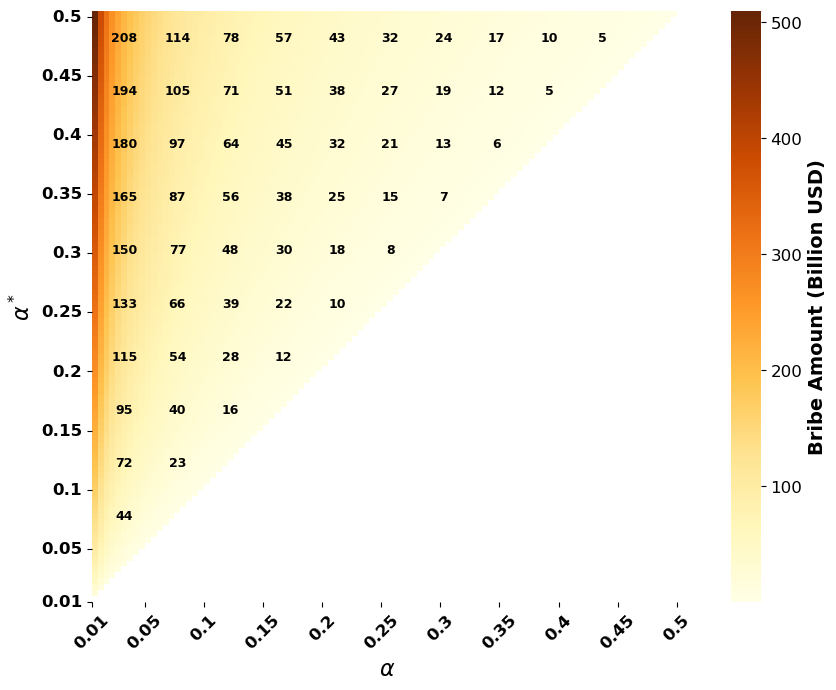

In [ ]:
def k_star(N, alpha, alpha_star):
    if alpha_star <= alpha or alpha <= 0 or alpha_star > 0.5:
        return np.nan
    return int(math.ceil(N * (1.0 - alpha / alpha_star)))


def optimal_bribe_total_cost_usd(N, alpha, alpha_star, r, Y, eth_usd):
    k = k_star(N, alpha, alpha_star)
    if not np.isfinite(k) or k <= 0 or k >= N:
        return np.nan
    b_star_eth = g(N, k, Y, r) + g(N, k - 1, Y, r)
    if not np.isfinite(b_star_eth) or b_star_eth <= 0:
        return np.nan
    return k * b_star_eth * eth_usd


alpha_vals = np.linspace(0.01, 0.5, 100)
alpha_star_vals = np.linspace(0.01, 0.5, 100)

bribe_cost_usd = np.full(
    (len(alpha_star_vals), len(alpha_vals)), np.nan, dtype=np.float64
)
for i, a_star in enumerate(alpha_star_vals):
    for j, a in enumerate(alpha_vals):
        bribe_cost_usd[i, j] = optimal_bribe_total_cost_usd(
            noOfValidators, a, a_star, r, Y, eth_usd_rate
        )


def build_ticks(vals, step=0.05):
    major = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    idx = [int(np.argmin(np.abs(vals - v))) for v in major]
    lab = [f"{v:.2f}" for v in major]
    return idx, lab


xticks_idx, xticks = build_ticks(alpha_vals, step=0.05)
yticks_idx, yticks = build_ticks(alpha_star_vals, step=0.05)

vmin = np.nanmin(bribe_cost_usd)
vmax = np.nanmax(bribe_cost_usd)

matplot2tikz.clean_figure()

# ticks from 0.01

alpha_vals = np.linspace(0.01, 0.5, 100)
alpha_star_vals = np.linspace(0.01, 0.5, 100)

attack_time_days = np.full((len(alpha_star_vals), len(alpha_vals)), np.nan)

vmin = np.nanmin(attack_time_days)
vmax = np.nanmax(attack_time_days)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)
yticks_idx = np.linspace(0, len(alpha_star_vals) - 1, 11, dtype=int)
yticks = np.round(alpha_star_vals[yticks_idx], 2)


plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    bribe_cost_usd / 1e9,
    cmap="YlOrBr",
    mask=~np.isfinite(bribe_cost_usd),
    square=True,
    vmin=vmin / 1e9 if np.isfinite(vmin) else None,
    vmax=vmax / 1e9 if np.isfinite(vmax) else None,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight="bold")
ax.set_ylabel(r"$\alpha^*$", fontsize=16, fontweight="bold")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=45, ha="center", fontsize=12, fontweight="bold")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=12, fontweight="bold")

ax.invert_yaxis()

for i in range(5, len(alpha_star_vals), 9):
    for j in range(5, len(alpha_vals), 9):
        val = bribe_cost_usd[i, j]
        if np.isfinite(val):
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{val/1e9:.0f}",
                ha="center",
                va="center",
                fontsize=9,
                fontweight="bold",
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Bribe Amount (Billion USD)", fontsize=14, fontweight="bold")

plt.tight_layout()
matplot2tikz.save("PayToExit_BribeHeatmap.tex")
plt.show()

/var/folders/bs/mcr4twx959ndzlf0j55vycz00000gn/T/ipykernel_14583/2997005699.py:51: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(bribe_cost_usd)
/var/folders/bs/mcr4twx959ndzlf0j55vycz00000gn/T/ipykernel_14583/2997005699.py:52: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(bribe_cost_usd)
/opt/anaconda3/envs/brib2/lib/python3.13/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/anaconda3/envs/brib2/lib/python3.13/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


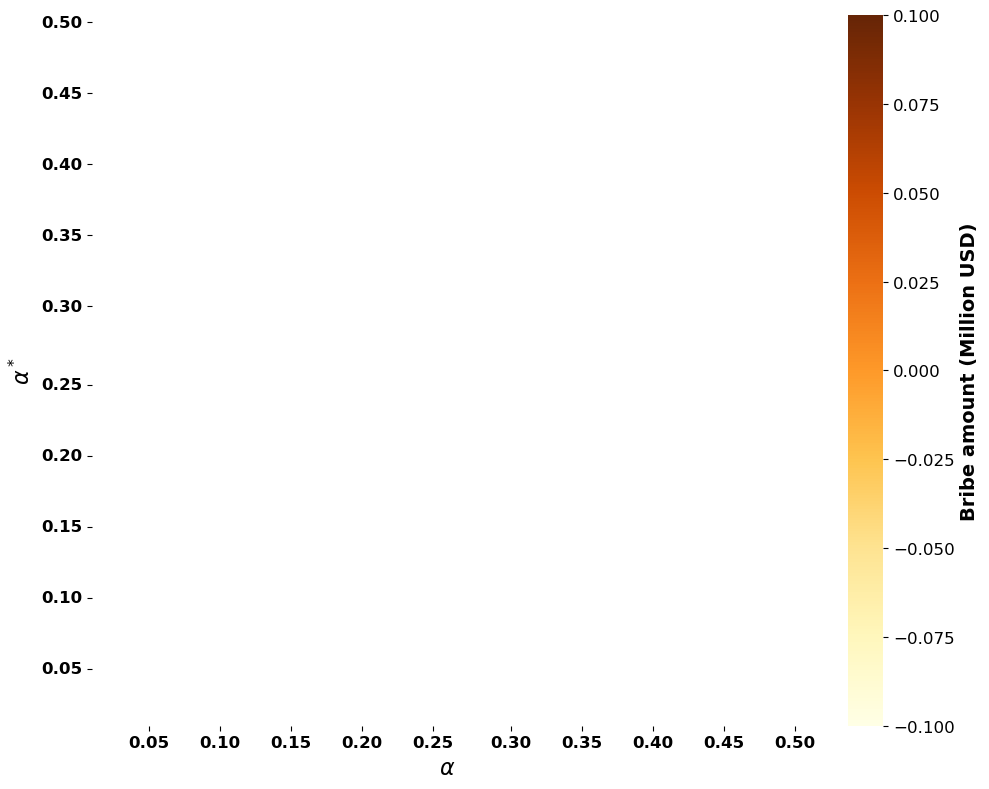

In [ ]:
# MEV_COEF = 267_161.5
MEV_COEF = 1_078_543.3  # a cikkben használt érték


def getMEVapr(N):
    return MEV_COEF / N


def R(N):
    return 32 * (getAPR(N) + getMEVapr(N)) / 100.0


def g_MEV(N, k, Y=Y, r=r):
    n2 = N - k
    if n2 < 1:
        return float("nan")
    return (R(n2) - R(N)) * (1 - (1 + r) ** (-Y)) / r


def k_required(N, alpha, alpha_star):
    returnalpha_star - alpha


def optimal_bribe_total_cost_usd_MEV(
    N, alpha, alpha_star, r=r, Y=Y, eth_usd=eth_usd_rate
):
    if alpha <= 0 or alpha_star <= alpha or alpha_star > 0.5:
        return float("nan")
    k_star = k_required(N, alpha, alpha_star)
    if k_star <= 0 or k_star >= N:
        return float("nan")
    b_star_eth = g_MEV(N, k_star - 1, Y, r)
    if not (b_star_eth > 0):
        return float("nan")
    total_eth = k_star * b_star_eth
    return total_eth * eth_usd  # USD


alpha_vals = np.linspace(0.01, 0.5, 100)
alpha_star_vals = np.linspace(0.01, 0.5, 100)

bribe_cost_usd = np.full((len(alpha_star_vals), len(alpha_vals)), np.nan, dtype=float)
for i, a_star in enumerate(alpha_star_vals):
    for j, a in enumerate(alpha_vals):
        bribe_cost_usd[i, j] = optimal_bribe_total_cost_usd_MEV(
            noOfValidators, a, a_star
        )


def build_ticks(vals, step=0.05):
    major = np.arange(0.05, 0.501, step)
    idx = [int(np.argmin(np.abs(vals - v))) for v in major]
    lab = [f"{v:.2f}" for v in major]
    return idx, lab


xticks_idx, xticks = build_ticks(alpha_vals, step=0.05)
yticks_idx, yticks = build_ticks(alpha_star_vals, step=0.05)

vmin = np.nanmin(bribe_cost_usd)
vmax = np.nanmax(bribe_cost_usd)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    bribe_cost_usd / 1e6,
    cmap="YlOrBr",
    mask=~np.isfinite(bribe_cost_usd),
    square=True,
    cbar_kws={"label": "Bribe amount (Million USD)"},
    vmin=vmin / 1e6 if np.isfinite(vmin) else None,
    vmax=vmax / 1e6 if np.isfinite(vmax) else None,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight="bold")
ax.set_ylabel(r"$\alpha^*$", fontsize=16, fontweight="bold")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=12, fontweight="bold")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=12, fontweight="bold")

ax.invert_yaxis()

for i in range(5, len(alpha_star_vals), 14):
    for j in range(5, len(alpha_vals), 14):
        val = bribe_cost_usd[i, j]
        if np.isfinite(val):
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{val/1e6:.0f}",
                ha="center",
                va="center",
                fontsize=9,
                fontweight="bold",
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Bribe amount (Million USD)", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

### Pay to exit: attack duration


<Figure size 640x480 with 0 Axes>

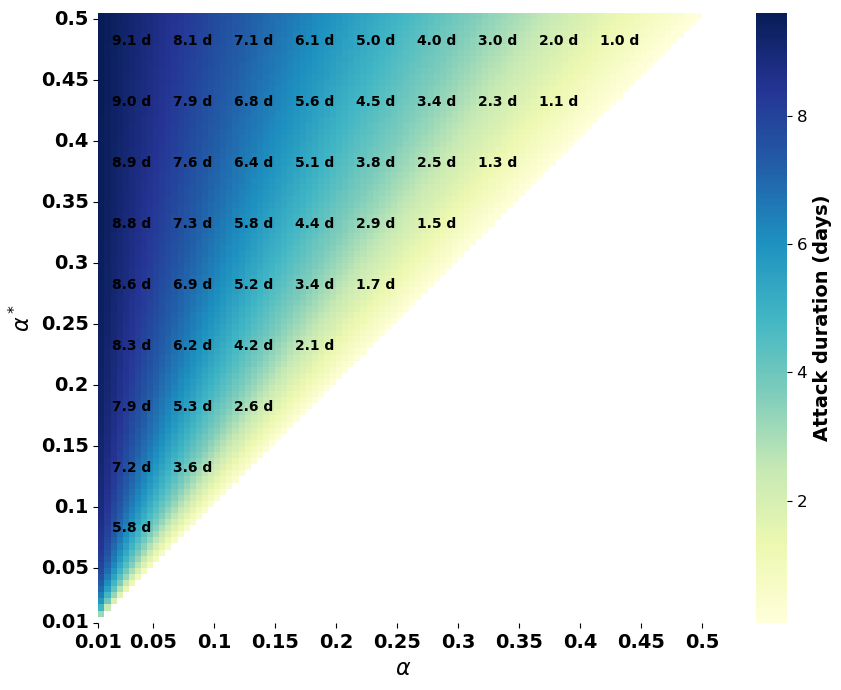

In [61]:
validators_per_block = 16
block_time_sec = 12

alpha_vals = np.linspace(0.01, 0.5, 100)
alpha_star_vals = np.linspace(0.01, 0.5, 100)

attack_time_days = np.full((len(alpha_star_vals), len(alpha_vals)), np.nan)

for i, alpha_star in enumerate(alpha_star_vals):
    for j, alpha in enumerate(alpha_vals):
        if alpha_star > alpha:
            delta_validators = math.ceil(
                noOfValidators * (alpha_star - alpha) / alpha_star
            )

            blocks_needed = delta_validators / validators_per_block
            time_days = (blocks_needed * block_time_sec) / 86400.0
            attack_time_days[i, j] = time_days

vmin = np.nanmin(attack_time_days)
vmax = np.nanmax(attack_time_days)

xticks_idx = np.linspace(0, len(alpha_vals) - 1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)
yticks_idx = np.linspace(0, len(alpha_star_vals) - 1, 11, dtype=int)
yticks = np.round(alpha_star_vals[yticks_idx], 2)

matplot2tikz.clean_figure()

plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    attack_time_days,
    cmap="YlGnBu",
    mask=np.isnan(attack_time_days),
    square=True,
    xticklabels=xticks,
    yticklabels=yticks,
    cbar_kws={"label": "Attack duration (days)"},
    vmin=vmin,
    vmax=vmax,
)

ax.set_xlabel(r"$\alpha$", fontsize=16, fontweight="bold")
ax.set_ylabel(r"$\alpha^*$", fontsize=16, fontweight="bold")

ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha="center", fontsize=14, fontweight="bold")
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va="center", fontsize=14, fontweight="bold")

ax.invert_yaxis()

for i in range(5, len(alpha_star_vals), 10):
    for j in range(5, len(alpha_vals), 10):
        value = attack_time_days[i, j]
        if not np.isnan(value):
            txt = f"{value:.1f} d" if value < 100 else f"{value:.0f} d"
            ax.text(
                j + 0.5,
                i + 0.5,
                txt,
                ha="center",
                va="center",
                fontsize=10,
                fontweight="bold",
                color="black",
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Attack duration (days)", fontsize=14, fontweight="bold")

plt.tight_layout()
# plt.savefig("PayToExit_AttackDuration_days.pdf", format="pdf", bbox_inches="tight")
matplot2tikz.save("PayToExit_AttackDuration_days.tex")
plt.show()

### Pay-To-Exit gas cost vs number of blocks


In [ ]:
validators_per_block = 32
offer_gas = 60000
take_gas = 1150660
total_gas_per_validator = offer_gas + take_gas

gwei_price = 2.084 / 1e9
eth_usd_price = 3668.77

blocks = list(range(1, 21))
eth_costs = []
usd_costs = []

for b in blocks:
    total_validators = b * validators_per_block
    total_gas = total_validators * total_gas_per_validator
    eth_cost = total_gas * gwei_price
    usd_cost = eth_cost * eth_usd_price
    eth_costs.append(eth_cost)
    usd_costs.append(usd_cost)

plt.figure(figsize=(8, 5))
plt.plot(blocks, eth_costs, marker="o", color="darkred")
plt.xlabel("Number of manipulated blocks")
plt.ylabel("Total gas cost (ETH)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Pay to bias


### gas cost vs number of tail slots


In [ ]:
tail_slots = list(range(1, 11))

base_gas_per_verification = 1150660  # from Table2

gas_costs = [k * base_gas_per_verification for k in tail_slots]

eth_usd_price = 3668.77
gwei_price = 2.084 / 1e9  # ETH
usd_costs = [gas * gwei_price * eth_usd_price for gas in gas_costs]
eth_costs = [gas * gwei_price for gas in gas_costs]


plt.figure(figsize=(8, 5))
plt.plot(tail_slots, eth_costs, marker="o", color="navy")
plt.xlabel("Number of tail slots (k)")
plt.ylabel("Gas cost (ETH)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
tail_slots = list(range(1, 11))

gas_take_bribe = 1150660
gas_offer_bribe = 19678

gwei_price_eth = 2.084 / 1e9
eth_usd_price = 3668.77

eth_cost_take = [k * gas_take_bribe * gwei_price_eth for k in tail_slots]
eth_cost_offer = [k * gas_offer_bribe * gwei_price_eth for k in tail_slots]
eth_cost_total = [take + offer for take, offer in zip(eth_cost_take, eth_cost_offer)]

plt.figure(figsize=(8, 5))
plt.plot(tail_slots, eth_cost_take, label="takeBribe()", marker="o", color="navy")
plt.plot(tail_slots, eth_cost_offer, label="offerBribe()", marker="s", color="green")
plt.plot(
    tail_slots, eth_cost_total, label="Total cost", linestyle="--", color="darkorange"
)

plt.xlabel("Number of tail slots (k)")
plt.ylabel("Gas cost (ETH)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Histogram


In [ ]:
tail_slots = list(range(1, 11))

gas_take_bribe = 1150660
gas_offer_bribe = 19678

gwei_price_eth = 2.084 / 1e9

eth_cost_take = [k * gas_take_bribe * gwei_price_eth for k in tail_slots]
eth_cost_offer = [k * gas_offer_bribe * gwei_price_eth for k in tail_slots]

x = np.arange(len(tail_slots))

plt.figure(figsize=(9, 5))
plt.bar(x, eth_cost_take, label="takeBribe()", color="navy")
plt.bar(x, eth_cost_offer, bottom=eth_cost_take, label="offerBribe()", color="green")

plt.xticks(x, tail_slots)
plt.xlabel("Number of tail slots (k)")
plt.ylabel("Gas cost (ETH)")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

#### Gas Cost vs. Published Slot Ratio


In [ ]:
k = 10  # tail slot
gas_per_slot = 93156
gas_price_gwei = 3.66877
gwei_to_eth = 1e-9

ratios = np.linspace(0, 1, 11)

published_slots = ratios * k

total_gas = published_slots * gas_per_slot
total_eth_cost = total_gas * gas_price_gwei * gwei_to_eth

plt.figure(figsize=(8, 6))
plt.plot(ratios, total_eth_cost, marker="o", color="darkgreen")
plt.xlabel("Published tail slots ratio")
plt.ylabel("Gas cost (ETH)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Countermeasures


In [ ]:
date_range = pd.date_range(start="2020-01-01", end="2025-01-01", freq="D")
num_days = len(date_range)

eth_supply = 110 + 0.005 * (
    pd.Series(range(num_days)) + (np.random.randn(num_days) * 0.2).cumsum()
)
eth_supply = eth_supply.round(3)

price = (
    2000
    + (np.sin(np.linspace(0, 20, num_days)) * 200)
    + (np.random.randn(num_days) * 100).cumsum()
)
price = pd.Series(price).clip(lower=100)

df = pd.DataFrame(
    {"date": date_range, "eth_supply_millions": eth_supply, "eth_usd_price": price}
)
df["eth_supply"] = df["eth_supply_millions"] * 1e6
df["eth_inflation"] = df["eth_supply"].pct_change()
df["price_return"] = df["eth_usd_price"].pct_change()
df.dropna(inplace=True)
df["eth_inflation_percent"] = df["eth_inflation"] * 100
print(df.tail())

In [ ]:
import statsmodels.api as sm

plt.figure(figsize=(8, 6))
sns.scatterplot(x="eth_inflation_percent", y="price_return", data=df, alpha=0.5)
plt.xlabel("daily ETH Inflation (%)")
plt.ylabel("ETH/USD Price Return (daily)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation
correlation = df["eth_inflation"].corr(df["price_return"])
print(f"Korreláció: {correlation:.4f}")

# Linear regression
X = sm.add_constant(df["eth_inflation"])
y = df["price_return"]
model = sm.OLS(y, X).fit()
print(model.summary())

### ETH/USD Price vs Issuance Rate


In [ ]:
initial_price = 2000
issuance_rates = np.linspace(0.01, 0.2, 50)


# 1. Quantity theory of money (MV = PY) model
def quantity_theory_model(M0=100, V=5, Y=500):
    prices = []
    for i_rate in issuance_rates:
        M = M0 * (1 + i_rate)
        P = (M * V) / Y
        eth_price = initial_price * (1 / P)  # ETH/USD
        prices.append(eth_price)
    return prices


# 2. Stochastic modell (Black)
def stochastic_black_model(mu=0.08, sigma=0.3, T=1, dt=1 / 252):
    time_grid = np.arange(0, T, dt)
    final_prices = []
    for pi in issuance_rates:
        price = initial_price
        for _ in time_grid:
            dW = np.random.normal(0, np.sqrt(dt))
            price *= np.exp((mu - pi - 0.5 * sigma**2) * dt + sigma * dW)
        final_prices.append(price)
    return final_prices


# 3.Regression model
def regression_model(beta_0=0.05, beta_1=-0.8, T=1):
    log_returns = beta_0 + beta_1 * issuance_rates
    prices = initial_price * np.exp(log_returns * T)
    return prices


qt_prices = quantity_theory_model()
stoch_prices = stochastic_black_model()
reg_prices = regression_model()

df = pd.DataFrame(
    {
        "Issuance Rate (%)": issuance_rates * 100,
        "QuantityTheory": qt_prices,
        "StochasticModel": stoch_prices,
        "RegressionModel": reg_prices,
    }
)
# print(df.round(2))

plt.figure(figsize=(10, 6))
plt.plot(issuance_rates * 100, qt_prices, label="Quantity theory", linewidth=2)
plt.plot(issuance_rates * 100, stoch_prices, label="Stochastic (Black)", linewidth=2)
plt.plot(issuance_rates * 100, reg_prices, label="Regression model", linewidth=2)
plt.xlabel("Issuance rate (%)")
plt.ylabel("Simulated ETH/USD price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### ETH/USD price - time graph


In [ ]:
initial_price = 1000
years = 10
time = np.arange(0, years + 1)

issuance_rate = np.linspace(0.01, 0.10, len(time))


def quantity_theory(M0=100, V=1, Y=100):
    prices = []
    for i, pi in enumerate(issuance_rate):
        M = M0 * (1 + pi) ** i
        P = (M * V) / Y
        price = initial_price * (1 / P)
        prices.append(price)
    return prices


def stochastic_model(mu=0.05, sigma=0.2):
    dt = 1
    price = initial_price
    prices = [price]
    for i in range(1, len(time)):
        pi = issuance_rate[i]
        dW = np.random.normal(0, np.sqrt(dt))
        price *= np.exp((mu - pi - 0.5 * sigma**2) * dt + sigma * dW)
        prices.append(price)
    return prices


def regression_model(beta_0=0.05, beta_1=-1.5):
    log_returns = beta_0 + beta_1 * issuance_rate
    prices = [initial_price]
    for i in range(1, len(time)):
        new_price = prices[-1] * np.exp(log_returns[i])
        prices.append(new_price)
    return prices


qt_prices = quantity_theory()
stoch_prices = stochastic_model()
reg_prices = regression_model()

fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axs[0].plot(time, qt_prices, color="green", label="Price Level (ETH/USD)")
axs[0].set_title("Quantity theory of money")
axs[0].set_ylabel("Price Level")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(time, stoch_prices, color="blue", label="ETH/USD price (stochastic)")
axs[1].set_title("Stochastic ETH/USD model with issuance as inflation")
axs[1].set_ylabel("Price")
axs[1].grid(True)
axs[1].legend()

axs[2].plot(time, reg_prices, color="red", label="ETH/USD price (regression model)")
axs[2].set_title("Regression-based ETH/USD price from issuance")
axs[2].set_xlabel("Time (years)")
axs[2].set_ylabel("ETH/USD price")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(time, qt_prices, color="green", label="Quantity theory of money")
plt.plot(time, stoch_prices, color="blue", label="Stochastic")
plt.plot(time, reg_prices, color="red", label="Regression model")
plt.xlabel("Time (years)")
plt.ylabel("ETH/USD price")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()